In [3]:
import librosa
import librosa.display
import matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
# from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm
import numpy
import os
import scipy

### Problem 1. Some clustering

In [4]:
class PCA():
    def __init__(self, n_components: int) -> None:
        self.n_components = n_components
        return

    def _X_mean(self, X: numpy.ndarray) -> numpy.ndarray:
        X_mean = numpy.mean(a=X, axis=1, keepdims=True)   # mean of matrix X  [X, ]
        one_vec = numpy.ones(shape=(1, X.shape[1]))       # [1 x observations]
        X_mean_mat = X_mean@one_vec                       # features mean matrix   [# of features x # of samples]
        X_mean_center = X - X_mean_mat                    # mean-centered matrix X [# of features x # of samples]
        return X_mean_center

    def fit_transform(self, X: numpy.ndarray) -> tuple[numpy.ndarray, numpy.ndarray]:
        X_mean_center = self._X_mean(X=X)
        C = numpy.cov(m=X_mean_center, rowvar=True, bias=False)
        eigenvals, eigenvecs = scipy.linalg.eig(a=C)
        eigenval_indices = numpy.argsort(a=eigenvals)[::-1]
        eigenvals = eigenvals[eigenval_indices].real
        eigenvecs = eigenvecs[:, eigenval_indices].real
        Lambda = scipy.linalg.inv(a=numpy.diag(v=numpy.sqrt(eigenvals[:self.n_components])))
        U = eigenvecs[:, :self.n_components]
        W = Lambda@U.T
        Y = W@X_mean_center
        return W, Y

    def reconstruct(self, X: numpy.ndarray) -> numpy.ndarray:
        X_mean_mat, X_mean_center = self._X_mean(X=X)
        Z = self.U[:, :self.n_components].T@X_mean_center
        X_hat = self.U[:, :self.n_components]@Z+X_mean_mat
        return X_hat

In [5]:
class KMeans():
    def __init__(self, n_clusters: int, tol: float) -> None:
        self.n_clusters = n_clusters
        self.tol = tol
        self.cluster_centers_ = None
        self.labels_ = None

        return

    def fit(self, X: numpy.ndarray) -> tuple[numpy.ndarray, numpy.ndarray]:
        cluster_center_indices = numpy.random.choice(a=X.shape[0], size=self.n_clusters, replace=False)
        cluster_centers = X[cluster_center_indices]
    
        while True:
            dists = scipy.linalg.norm(a=(X[:, numpy.newaxis]-cluster_centers), axis=2)
            labels = numpy.argmin(a=dists, axis=1)

            new_cluster_centers = []
            for i in range(self.n_clusters):
                cluster_mu = X[labels==i].mean(axis=0)
                new_cluster_centers.append(cluster_mu)
            new_cluster_centers = numpy.vstack(tup=new_cluster_centers, dtype=numpy.float32)

            if numpy.all(scipy.linalg.norm(a=(new_cluster_centers-cluster_centers), axis=0) <= self.tol):
                break

            cluster_centers = new_cluster_centers

        self.cluster_centers_ = cluster_centers
        self.labels_ = labels

        return self

    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        dists = scipy.linalg.norm(a=(X[:, numpy.newaxis]-self.cluster_centers_), axis=2)

        return numpy.argmin(a=dists, axis=1)

In [6]:
def time_to_frames(times: float, sr: int, hop_length: int, n_fft: int=None) -> int:
    return librosa.time_to_frames(times=times, sr=sr, hop_length=hop_length, n_fft=n_fft)

def create_labels(label_filepath: str, sr: int, hop_length: int, n_fft: int=None) -> numpy.ndarray:
    dtypes = [("start_time", "float64"), ("end_time", "float64"), ("label", "U10")]
    label_data = np.genfromtxt(fname=label_filepath, dtype=dtypes, delimiter='\t', skip_header=0, skip_footer=0)

    classes = numpy.array([label_info[2] for label_info in label_data])
    classes = numpy.unique(ar=classes)

    frame_labels = numpy.array(object=[], dtype=numpy.uint8)
    for label_info in label_data:
        start_time, end_time, label = label_info
        start_frame = time_to_frames(times=start_time, sr=sr, hop_length=hop_length, n_fft=N_FFT)
        end_frame = time_to_frames(times=end_time, sr=sr, hop_length=hop_length, n_fft=N_FFT)
        label_id = numpy.where(classes==label)[0]
        labels = numpy.full(shape=(end_frame-start_frame), fill_value=label_id, dtype=numpy.uint8)
        frame_labels = numpy.append(arr=frame_labels, values=labels)
    frame_labels = numpy.append(arr=frame_labels, values=label_id)
    print(frame_labels.shape)
    
    return frame_labels

In [7]:
SAMPLING_RATE = 22050
N_FFT = 2048
HOP_LENGTH = N_FFT//4
WIN_LENGTH = N_FFT//2


audio_filepath = "friends.wav"

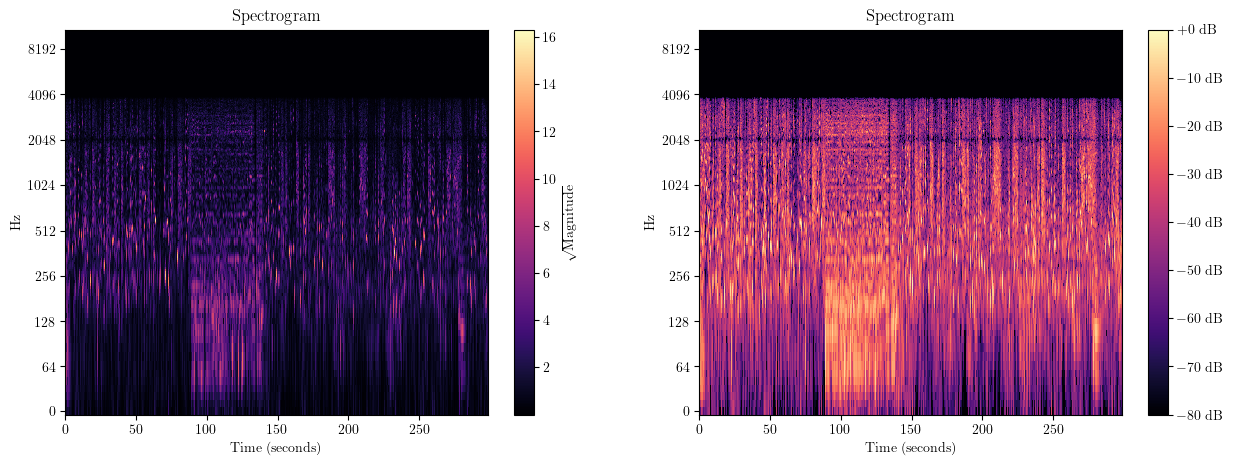

In [8]:
y, _ = librosa.load(path=audio_filepath, sr=SAMPLING_RATE, dtype=numpy.float64)
spec = librosa.stft(y=y, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
spec = numpy.abs(spec)
spec_sqrt = numpy.sqrt(spec)

matplotlib.pyplot.rc('font', family='serif')
matplotlib.pyplot.rc(group="text", usetex=True)
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15, 5))
img_0 = librosa.display.specshow(data=spec_sqrt, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT,
                                 win_length=WIN_LENGTH, x_axis='s', y_axis='log', ax=ax[0])
fig.colorbar(img_0, ax=[ax[0]], label=r"$\sqrt{\textnormal{Magnitude}}$")
ax[0].set_title("Spectrogram")

spec_db = librosa.amplitude_to_db(S=spec, ref=numpy.max)
img_1 = librosa.display.specshow(data=spec_db, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT,
                                 win_length=WIN_LENGTH, x_axis='s', y_axis='log', ax=ax[1])
fig.colorbar(img_1, ax=[ax[1]], format=r"$%+2.0f$ dB")
ax[1].set_title("Spectrogram")

matplotlib.pyplot.show()

In [113]:
print(spec.shape)
pca = PCA(n_components=40)
W, Y = pca.fit_transform(X=spec)
print(Y.shape)

(1025, 12865)
(40, 12865)


In [107]:
mfccs = librosa.feature.mfcc(y=y, sr=SAMPLING_RATE, n_mfcc=20, n_fft=N_FFT, hop_length=HOP_LENGTH,
                             win_length=WIN_LENGTH)
print(mfccs.shape)
pca1 = PCA(n_components=10)
W1, Y1 = pca1.fit_transform(X=mfccs)

feat = numpy.vstack((Y, Y1), dtype=numpy.float64)
print(feat.shape)

(20, 12865)
(70, 12865)


In [296]:
kmeans = KMeans(n_clusters=3, tol=1e-5).fit(X=spec.T)
labels = kmeans.predict(X=spec.T)

In [297]:
print(labels.shape)
print(labels[7000:8000])

(12865,)
[0 2 0 2 0 2 2 2 2 2 2 2 0 0 0 0 0 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1
 1 1 1 0 1 0 0 0 0 0 2 2 2 2 0 2 0 2 2 1 1 1 1 0 0 0 0 0 0 0 2 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 2 2 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 0 1 0 2 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 0 1 1 0 1 1 1 1 0 2 2 2 0 2 1 1 1 0 0 0 1 0 1 0 0 2 2 0 0
 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1 2 2 0 0 0 0 0 0 0
 2 0 2 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 2 2 2 2 2 1 1 1 1 1 0 0
 0 0 0 0 0 2 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 2 2 0 0 0 1 1 1 1 1 1 1 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 2 2 2 0 0 0 0 0 0 2 0 0 2 0 0 0 0
 0 0 0 2 2 2 2 0

In [127]:
# times = librosa.frames_to_time(frames=numpy.arange(labels.shape[0]), sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT)
# print(times.shape)
# print(times[:1000])

In [129]:
label_filepath = "labels.txt"

frame_labels = create_labels(label_filepath=label_filepath, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT)
print(frame_labels[7000:8000])

(12865,)
[2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2

In [ ]:
frame_times = librosa.frames_to_time(frames=np.arange(spec_db.shape[1]), sr=sr)
print(frame_times)
print(len(frame_times))

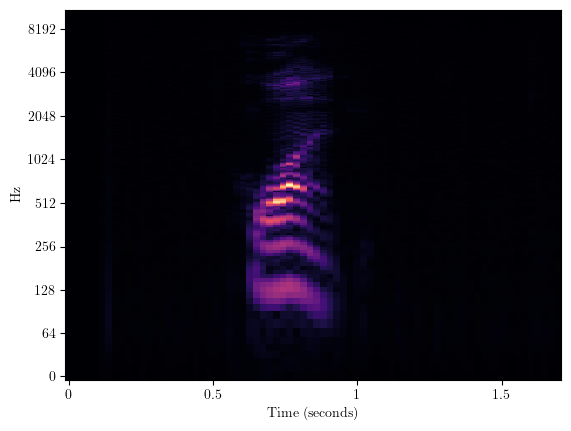

In [14]:
SAMPLING_RATE = 22050
N_FFT = 2048
HOP_LENGTH = N_FFT//4
WIN_LENGTH = N_FFT//2

y, _ = librosa.load(path="digits/one/1 (1).wav", sr=SAMPLING_RATE, dtype=numpy.float64)
spec = librosa.stft(y=y, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
spec = numpy.abs(spec)
spec_sqrt = numpy.sqrt(spec)

librosa.display.specshow(data=spec_sqrt, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_fft=N_FFT,
                                 win_length=WIN_LENGTH, x_axis='s', y_axis='log')
matplotlib.pyplot.show()

In [116]:
# K-means clustering
kmeans = sklearn.cluster.KMeans(n_clusters=3, tol=1e-3)
kmeans_labels = kmeans.fit_predict(spec.T)

/Users/hongbozheng/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [119]:
print(len(kmeans_labels))
print(kmeans_labels[:1000])

12865
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 1 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 2 2 0 0 0 0 2 2 2 2 2 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2
 2 0 2 2 2 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 2 2 2 0 0 1 0 1 2 2 2 2 0 0 0 0 2 2 2 0 0 2 2 2 2 0 2 1 0 0 0 0
 2 2 2 2 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0
 0 2 1 0 0 2 1 0 0 0 2 2 2 0 0 0 0 0 0 0 0 2 2 2 0 0 0 1 1 1 0 1 1 1 1 2 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 1 2 2 0 0 0 0 0 

In [118]:
# GMM clustering
gmm = GaussianMixture(n_components=3)
gmm_labels = gmm.fit_predict(spec.T)

In [120]:
print(len(gmm_labels))
print(gmm_labels[:1000])

12865
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 0 1 1 1 1 1 0 0 0 0 2 0
 2 2 2 2 2 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 1 1 1
 1 1 0 2 2 2 2 2 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 1 0 0 0 0 2 2 2 1 1 0 1 0 2 2 2 2 0 0 2 2 2 2 2 2 1 1 1 1
 2 2 2 2 2 2 0 1 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 1
 1 2 0 1 1 2 0 1 1 0 0 2 2 1 1 0 0 0 0 0 1 2 2 2 1 1 0 0 0 1 1 0 0 0 0 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 1 1 0 

In [ ]:
# HMM clustering
hmm_model = hmm.GMMHMM(n_components=3)
hmm_model.fit(spec.T)
hmm_labels = hmm_model.predict(spec.T)

### Problem 3. Activity recognition

In [389]:
def create_class_map(class_filepath: str, class_names: list[str]) -> dict:
    dtypes = [("labels", "uint8"), ("activity", "U20")]
    class_info = numpy.genfromtxt(fname=class_filepath, dtype=dtypes, delimiter=' ', skip_header=0, skip_footer=0)
    class_map = dict(class_info)
    class_map = {k-1: v for k, v in class_map.items() if v in class_names}

    return class_map

In [390]:
class HAR():
    def __init__(self, dataset_dir: str, classes: numpy.ndarray) -> None:
        self.classes = classes
        self.data = None
        self.labels = None
        self.__load_data(dataset_dir=dataset_dir)
        self.__load_labels(dataset_dir=dataset_dir)
        self.__filter(classes=classes)
        self.data_train_ = None
        self.labels_train_ = None
        self.data_test_ = None
        self.labels_test_ = None

        return

    def __load_data(self, dataset_dir: str) -> None:
        x_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_x_test.txt")
        y_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_y_test.txt")
        z_filepath = os.path.join(dataset_dir, "test", "Inertial_Signals", "total_acc_z_test.txt")
        x = numpy.loadtxt(fname=x_filepath, dtype=numpy.float64)
        y = numpy.loadtxt(fname=y_filepath, dtype=numpy.float64)
        z = numpy.loadtxt(fname=z_filepath, dtype=numpy.float64)
        self.data = numpy.stack(arrays=(x, y, z), axis=2)

        return

    def __load_labels(self, dataset_dir: str) -> None:
        label_filepath = os.path.join(dataset_dir, "test", "y_test.txt")
        self.labels = numpy.loadtxt(fname=label_filepath, dtype=numpy.uint8)
        self.labels -= 1

        return

    def __filter(self, classes: list[int]) -> None:
        mask = numpy.isin(element=self.labels, test_elements=classes)
        N = numpy.count_nonzero(a=mask)
        self.data = self.data[mask]
        self.labels = self.labels[mask]

        assert N == self.data.shape[0] == self.labels.shape[0]

    def train_test_split(
            self,
            test_pct: float,
            train_pct: float,
            rand_state: int
    ) -> tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]:
        if rand_state is not None:
            numpy.random.seed(seed=rand_state)

        mu = numpy.mean(a=self.data, axis=0, dtype=numpy.float64)
        self.data -= mu

        data_train = []
        labels_train = []
        data_test = []
        labels_test = []
        for cls in self.classes:
            indices_cls = numpy.where(self.labels==cls)[0]
            test_size = int(indices_cls.shape[0]*test_pct)
            indices_cls_test = numpy.random.choice(a=indices_cls, size=test_size, replace=False)
            mask = numpy.isin(element=indices_cls, test_elements=indices_cls_test, assume_unique=True)
            indices_cls_train = indices_cls[~mask]
            data_train.append(self.data[indices_cls_train])
            labels_train.append(self.labels[indices_cls_train])
            data_test.append(self.data[indices_cls_test])
            labels_test.append(self.labels[indices_cls_test])


        self.data_train_ = data_train
        self.labels_train_ = labels_train
        self.data_test_ = numpy.vstack(tup=data_test, dtype=numpy.float64)
        self.labels_test_ = numpy.hstack(tup=labels_test, dtype=numpy.uint8)
#         for a,b in zip(data_train, labels_train):
#             print(len(a), len(b))
#         print("-------")
#         for a,b in zip(data_test, labels_test):
#             print(a.shape, b.shape)
        

        return

In [391]:
class_filepath = "HAR/activity_labels.txt"
class_names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING"]

class_map = create_class_map(class_filepath=class_filepath, class_names=class_names)
print(class_map)

{0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS', 3: 'SITTING'}


In [392]:
dataset_dir = "HAR"



In [402]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tools.tools import add_constant
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


class ActRecog():
    def __init__(self, dataset_dir: str, class_map: dict, lag_order: int) -> None:
        self.classes = numpy.unique(ar=list(class_map.keys()))
        self.class_names = list(class_map.values())
        self.lag_order = lag_order
        self.har = HAR(dataset_dir=dataset_dir, classes=self.classes)
        self.har.train_test_split(test_pct=0.5, train_pct=0.5, rand_state=None)
        self.VAR_models_ = {}

        return

    def train_VAR_models(self):

        for i, cls in enumerate(self.classes):
            VAR_models_class = []

            for X, y in zip(self.har.data_train_[i], self.har.labels_train_[i]):
#                 X = add_constant(data=X, prepend=False)
#                 print(X.shape)
#                 print(X)
                model = VAR(X)
                var_res = model.fit(maxlags=10, method="ols", trend='c')
                coeff = var_res.params
#                 print(coeff.shape)
                lag_order = var_res.k_ar  # Get the lag order used in the model

                # Specify the number of steps to forecast into the future
                steps = 10  # Adjust this according to your needs

                # Forecast future values
                forecast_values = var_res.forecast(y=X[-lag_order:], steps=118)
                y_true = X[lag_order:]

                # Assuming 'y_true' is the true values for the forecast period
                # Calculate the loss (e.g., Mean Squared Error)
                mse = ((forecast_values - y_true)**2).mean()
#                 print(mse)
                #                 print(results.summary())
                VAR_models_class.append(var_res.params)
            VAR_models_class = numpy.stack(arrays=VAR_models_class, axis=0, dtype=numpy.float64)
            self.VAR_models_[i+1] = VAR_models_class

    def test_VAR_models(self):
        preds = numpy.array(object=[], dtype=numpy.uint8)
        for X, y in zip(self.har.data_test_, self.har.labels_test_):
            loss = numpy.array(object=[], dtype=numpy.float64)
            for cls in range(1, self.classes.size+1):
#                 print(cls)
#                 model = VAR(X)
#                 var_res = model.fit(maxlags=50, method="ols", trend='c')
#                 var_res.params = numpy.mean(a=self.VAR_models_[cls], axis=0)
#                 print(var_res.params)
#                 forcasts = var_res.forecast(y=X[-self.lag_order:], steps=78)
#                 print(var_res.params)
#                 print(forcasts)
                forecasts = []
                for step in range(118):
                    W = numpy.mean(a=self.VAR_models_[cls], axis=0)
                    X_test = X[-self.lag_order:].flatten(order='F')
                    X_test = X_test[:, numpy.newaxis]
                    X_test = numpy.append(X_test, 1)
    # #                 print(X_test.shape)
                    forecast = X_test@W
                    X_test = X_test[:-1]
                    X_test = numpy.reshape(a=X_test, newshape=(-1, 3), order='F')
                    X_test = numpy.vstack((X_test[1:], forecast))
                    forecasts.append(forecast)
                forecasts = numpy.vstack(tup=forecasts, dtype=numpy.float64)
                y_true = X[self.lag_order:self.lag_order+118]
                mse = ((forecasts - y_true)**2).mean()
                loss = numpy.append(arr=loss, values=mse)
            pred = numpy.argmin(a=loss, axis=0)
            preds = numpy.append(arr=preds, values=pred)
#             print(loss)
#             print(preds)
#             print(y)
#             break
        print(preds)
        print(self.har.labels_test_)
        report = classification_report(y_true=self.har.labels_test_, y_pred=preds, labels=self.classes,
                                       target_names=self.class_names)
        print(report)
        accuracy = accuracy_score(y_true=self.har.labels_test_, y_pred=preds)
        print(f'Accuracy: {accuracy}')

        return

actrecog = ActRecog(dataset_dir=dataset_dir, class_map=class_map, lag_order=10)
actrecog.train_VAR_models()

In [403]:
models = actrecog.VAR_models_
print(models[1].shape)

(248, 31, 3)


In [404]:
actrecog.test_VAR_models()

[0 0 3 2 0 0 0 1 3 0 0 0 0 3 3 0 1 0 3 0 3 2 2 0 0 0 0 3 0 3 3 3 3 2 2 3 0
 3 3 0 0 0 3 2 0 2 3 3 3 0 2 3 3 2 3 0 3 0 0 2 2 2 3 0 0 3 0 3 0 3 0 0 3 3
 0 1 3 3 3 1 3 0 1 3 3 2 0 0 3 0 0 2 0 0 2 0 2 3 3 0 0 3 1 0 2 0 3 3 3 3 0
 0 0 3 3 3 0 2 3 2 3 0 0 0 2 0 0 3 0 3 0 0 0 3 3 3 3 3 3 3 2 3 0 0 3 0 0 3
 0 0 0 2 0 3 3 0 0 3 0 0 0 1 0 1 3 2 0 1 0 2 3 2 2 0 3 3 2 0 3 1 0 2 0 2 3
 3 0 3 1 3 2 0 0 0 2 0 3 3 0 3 3 1 2 0 3 0 2 3 0 3 3 3 0 0 0 3 3 0 0 0 2 3
 3 3 2 3 0 3 0 0 3 3 0 2 2 3 3 3 3 2 3 2 3 3 0 0 0 2 0 0 0 3 0 0 0 0 0 3 3
 3 3 3 0 3 0 0 2 2 3 3 3 3 0 3 3 0 3 3 3 0 3 2 3 0 0 3 3 0 2 3 2 2 0 1 0 3
 1 0 0 0 0 0 0 0 3 0 3 3 0 1 3 0 0 0 0 3 0 2 3 3 0 1 0 1 1 2 3 0 1 3 2 3 2
 3 0 3 0 0 0 0 3 3 0 0 2 0 3 3 0 1 0 0 0 0 0 1 2 0 2 0 0 3 0 1 0 2 0 3 3 0
 0 0 2 2 0 3 0 0 3 0 3 0 0 3 0 0 2 0 3 3 0 1 0 3 3 0 0 3 3 0 0 1 0 3 2 0 3
 2 2 3 2 3 0 2 3 3 3 0 2 3 2 3 3 1 0 1 2 0 3 0 0 2 0 3 3 0 0 1 3 0 0 3 1 3
 3 0 0 3 3 3 2 0 3 3 3 3 3 3 0 0 3 0 0 0 0 1 3 2 3 3 3 0 2 3 0 2 3 3 0 1 0
 3 0 3 0 2 3 2 0 2 0 2 0 

In [35]:
models = actrecog.VAR_models_
print(models[1].shape)
mean = numpy.mean(a=models[1], axis=0, dtype=numpy.float64)
print(mean.shape)

(248, 241, 3)
(241, 3)
